In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests

In [27]:
wm_title=[]  
wm_date = []
wm_content = []
wm_rating = []

In [34]:
for i in range(1,100):
    ip=[]  
    url="https://www.amazon.in/Lenovo-IdeaPad-Windows-Platinum-81VV00JFIN/product-reviews/B087D3KCZK/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber=all_reviews"+str(i)
    response = requests.get(url)
    soup = bs(response.content,"html.parser")# creating soup object to iterate over the extracted content 

In [35]:
#Extracting Content of review
review = soup.find_all("span",{"data-hook":"review-body"})
review_content = []
for i in range(0,len(review)):
    review_content.append(review[i].get_text())
review_content[:] = [reviews.lstrip('\n') for reviews in review_content]
review_content[:] = [reviews.rstrip('\n') for reviews in review_content]
wm_content = wm_content + review_content  


In [36]:
# extracting Review Title
title = soup.find_all('a',class_='review-title-content')
review_title = []
for i in range(0,len(title)):
    review_title.append(title[i].get_text())
review_title[:] = [titles.lstrip('\n') for titles in review_title]
review_title[:] = [titles.rstrip('\n') for titles in review_title]
wm_title = wm_title + review_title
  
  

In [37]:
# Extracting Ratings
rating = soup.find_all('i',class_='review-rating')
review_rating = []
for i in range(2,len(rating)):
    review_rating.append(rating[i].get_text())
  #review_rating.pop(0)
  #review_rating.pop(0)
review_rating[:] = [reviews.rstrip(' out of 5 stars') for reviews in review_rating]
wm_rating = wm_rating + review_rating  
  
  

In [38]:
#Extracting dates of reviews
dates = soup.find_all('span',class_='review-date')
review_dates = []
for i in range(2,len(rating)):
    review_dates.append(dates[i].get_text())
review_dates[:] = [reviews.lstrip('Reviewed in India on') for reviews in review_dates]
#review_dates.pop(0)
#review_dates.pop(0)
wm_date  = wm_date + review_dates
  

In [39]:
print(len(wm_title))
print(len(wm_rating))
print(len(wm_content))
print(len(wm_date))



20
20
20
20


In [40]:
df = pd.DataFrame()
df['Title'] = wm_title
df['Ratings'] = wm_rating
df['Comments'] = wm_content
df['Date'] = wm_date


In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df['Ratings'] = df['Ratings'].astype(float)
df.head()


,Title,Ratings,Comments,Date
0,"Its an Ultrabook , So it comes with premium fe...",3.0,Update :- 08th June - Reduced my rating from...,2020-01-22
1,I am full satisfied at this price with best pe...,5.0,Really nice thin and light laptop at this pr...,2020-01-20
2,"Configuration wise good, quality and customer ...",3.0,29 Sep 2020 after 7 months of use:Reduing th...,2020-01-24
3,It's a mini i3 Beast...,5.0,If the specifications of this laptop meet yo...,2020-02-03
4,amazon cheated me by delivered old machine,1.0,i purchased laptop on june'20 and when i reg...,2020-06-28


In [46]:
from nltk.corpus import wordnet


In [47]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

In [48]:
import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [49]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


In [51]:
# clean text data
df["Comments"] = df["Comments"].apply(lambda x: clean_text(x))
df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].apply(lambda x: clean_text(x))
df.head()

,Title,Ratings,Comments,Date
0,ultrabook come premium feel build,3.0,update june reduce rating star battery need ca...,2020-01-22
1,full satisfied price best performance,5.0,really nice thin light laptop price one day de...,2020-01-20
2,configuration wise good quality customer servi...,3.0,sep month use:reduing rating star face issue l...,2020-01-24
3,mini beast,5.0,specification laptop meet requirement go witho...,2020-02-03
4,amazon cheat delivered old machine,1.0,purchase laptop registered device online lenov...,2020-06-28


In [52]:
#  add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [53]:
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Comments"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)


In [54]:
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound
0,ultrabook come premium feel build,3.0,update june reduce rating star battery need ca...,2020-01-22,0.026,0.774,0.200,0.9865
1,full satisfied price best performance,5.0,really nice thin light laptop price one day de...,2020-01-20,0.000,0.664,0.336,0.9492
2,configuration wise good quality customer servi...,3.0,sep month use:reduing rating star face issue l...,2020-01-24,0.087,0.662,0.251,0.9653
3,mini beast,5.0,specification laptop meet requirement go witho...,2020-02-03,0.081,0.655,0.264,0.7791
4,amazon cheat delivered old machine,1.0,purchase laptop registered device online lenov...,2020-06-28,0.000,0.839,0.161,0.5267
5,review lenovo ideapad generation intel core,5.0,look buy laptop ram core gen hard find price r...,2020-06-21,0.089,0.822,0.089,0.2500
6,good laptop battery faulty,2.0,delivery prompt laptop nice look feel well goo...,2020-02-01,0.066,0.712,0.222,0.6705
7,great deal,5.0,ice lake fhd ip ram ssd killer performance box...,2020-01-26,0.126,0.667,0.206,0.6741
8,poor man apple macbook air 👌🏻,5.0,bought wife love give star.build extremely sol...,2020-03-01,0.051,0.604,0.345,0.9905
9,poor quality product lenovo,1.0,receive lenovo june within day gentle usage sh...,2020-06-29,0.222,0.558,0.220,-0.0284


In [55]:
# add number of characters column
df["nb_chars"] = df["Comments"].apply(lambda x: len(x))


In [58]:
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words
0,ultrabook come premium feel build,3.0,update june reduce rating star battery need ca...,2020-01-22,0.026,0.774,0.200,0.9865,1366,206
1,full satisfied price best performance,5.0,really nice thin light laptop price one day de...,2020-01-20,0.000,0.664,0.336,0.9492,271,44
2,configuration wise good quality customer servi...,3.0,sep month use:reduing rating star face issue l...,2020-01-24,0.087,0.662,0.251,0.9653,694,96
3,mini beast,5.0,specification laptop meet requirement go witho...,2020-02-03,0.081,0.655,0.264,0.7791,290,42
4,amazon cheat delivered old machine,1.0,purchase laptop registered device online lenov...,2020-06-28,0.000,0.839,0.161,0.5267,175,25
5,review lenovo ideapad generation intel core,5.0,look buy laptop ram core gen hard find price r...,2020-06-21,0.089,0.822,0.089,0.2500,420,65
6,good laptop battery faulty,2.0,delivery prompt laptop nice look feel well goo...,2020-02-01,0.066,0.712,0.222,0.6705,190,29
7,great deal,5.0,ice lake fhd ip ram ssd killer performance box...,2020-01-26,0.126,0.667,0.206,0.6741,411,54
8,poor man apple macbook air 👌🏻,5.0,bought wife love give star.build extremely sol...,2020-03-01,0.051,0.604,0.345,0.9905,698,100
9,poor quality product lenovo,1.0,receive lenovo june within day gentle usage sh...,2020-06-29,0.222,0.558,0.220,-0.0284,299,44


In [56]:
# add number of words column
df["nb_words"] = df["Comments"].apply(lambda x: len(x.split(" ")))


In [59]:
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words
0,ultrabook come premium feel build,3.0,update june reduce rating star battery need ca...,2020-01-22,0.026,0.774,0.200,0.9865,1366,206
1,full satisfied price best performance,5.0,really nice thin light laptop price one day de...,2020-01-20,0.000,0.664,0.336,0.9492,271,44
2,configuration wise good quality customer servi...,3.0,sep month use:reduing rating star face issue l...,2020-01-24,0.087,0.662,0.251,0.9653,694,96
3,mini beast,5.0,specification laptop meet requirement go witho...,2020-02-03,0.081,0.655,0.264,0.7791,290,42
4,amazon cheat delivered old machine,1.0,purchase laptop registered device online lenov...,2020-06-28,0.000,0.839,0.161,0.5267,175,25
5,review lenovo ideapad generation intel core,5.0,look buy laptop ram core gen hard find price r...,2020-06-21,0.089,0.822,0.089,0.2500,420,65
6,good laptop battery faulty,2.0,delivery prompt laptop nice look feel well goo...,2020-02-01,0.066,0.712,0.222,0.6705,190,29
7,great deal,5.0,ice lake fhd ip ram ssd killer performance box...,2020-01-26,0.126,0.667,0.206,0.6741,411,54
8,poor man apple macbook air 👌🏻,5.0,bought wife love give star.build extremely sol...,2020-03-01,0.051,0.604,0.345,0.9905,698,100
9,poor quality product lenovo,1.0,receive lenovo june within day gentle usage sh...,2020-06-29,0.222,0.558,0.220,-0.0284,299,44


In [60]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [61]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Comments"].apply(lambda x: x.split(" ")))]


In [62]:
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)


In [63]:
# transform each Comment into a vector data
doc2vec_df = df["Comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)


In [64]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 6)
tfidf_result = tfidf.fit_transform(df["Comments"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)



In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


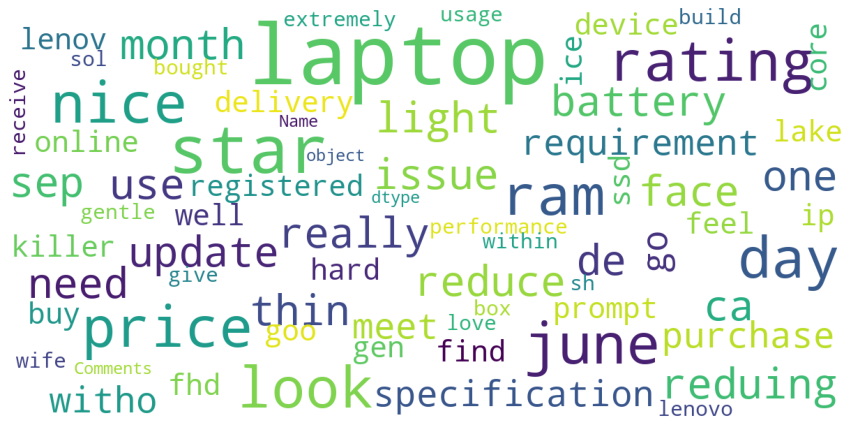

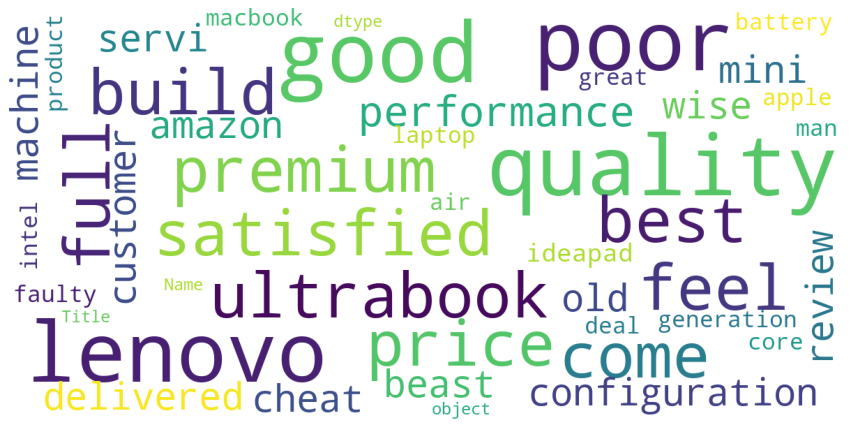

In [68]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(df["Comments"])
show_wordcloud(df["Title"])


In [69]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Comments", "pos"]].head(10)



,Comments,pos
18,bought wife love give star.build extremely sol...,0.345
8,bought wife love give star.build extremely sol...,0.345
1,really nice thin light laptop price one day de...,0.336
11,really nice thin light laptop price one day de...,0.336
3,specification laptop meet requirement go witho...,0.264
13,specification laptop meet requirement go witho...,0.264
2,sep month use:reduing rating star face issue l...,0.251
12,sep month use:reduing rating star face issue l...,0.251
16,delivery prompt laptop nice look feel well goo...,0.222
6,delivery prompt laptop nice look feel well goo...,0.222


In [70]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Comments", "neg"]].head(10)


,Comments,neg
19,receive lenovo june within day gentle usage sh...,0.222
9,receive lenovo june within day gentle usage sh...,0.222
7,ice lake fhd ip ram ssd killer performance box...,0.126
17,ice lake fhd ip ram ssd killer performance box...,0.126
15,look buy laptop ram core gen hard find price r...,0.089
5,look buy laptop ram core gen hard find price r...,0.089
2,sep month use:reduing rating star face issue l...,0.087
12,sep month use:reduing rating star face issue l...,0.087
3,specification laptop meet requirement go witho...,0.081
13,specification laptop meet requirement go witho...,0.081
